# 1. Problem Description

This project uses the **Kaggle “Real or Not? Disaster Tweets”** dataset, where the task is to classify tweets as either referring to a **real disaster** (`target = 1`) or **not a disaster** (`target = 0`). This is a binary text classification problem and a common example of **Natural Language Processing (NLP)** applied to social media data.

NLP focuses on transforming unstructured text into numerical representations that machine learning models can understand. In this challenge, the goal is to extract meaningful patterns from short, noisy tweets that may contain slang, emojis, abbreviations, and incomplete grammar.

---

# 2. Dataset Description

The dataset contains two files provided by Kaggle:

- **train.csv** — includes tweets and a binary label  
- **test.csv** — includes tweets but no labels (used for Kaggle submission)

### **Training Set Structure**
| Column      | Description |
|-------------|-------------|
| **id**      | Unique tweet identifier |
| **keyword** | Optional keyword extracted by Kaggle (may contain missing values) |
| **location**| Free-text user location (often noisy/missing) |
| **text**    | The tweet content |
| **target**  | 1 = disaster, 0 = not disaster |

### **Dataset Sizes**
- Training set: ~7600 rows  
- Test set: ~3200 rows  
- Text lengths vary from very short (under 20 characters) to full tweets (~140 characters).

The dataset has a mix of structured and unstructured fields, making it useful for exploring real-world preprocessing, EDA, and sequence modeling with RNN-based architectures.

In [1]:
import pandas as pd

train = pd.read_csv("../data/raw/train.csv")
test = pd.read_csv("../data/raw/test.csv")

train.head(), train.shape, test.shape

(   id keyword location                                               text  \
 0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
 1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
 2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
 3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
 4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
 
    target  
 0       1  
 1       1  
 2       1  
 3       1  
 4       1  ,
 (7613, 5),
 (3263, 4))

# 3. Exploratory Data Analysis (EDA)

The goal of this section is to inspect the structure and quality of the data, visualize important patterns, and determine what preprocessing is required before modeling.

In [2]:
train.info()
train.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [3]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

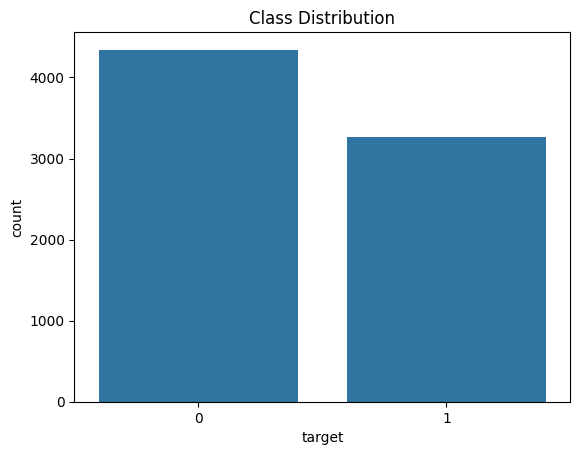

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train, x="target")
plt.title("Class Distribution")
plt.show()

The classes are moderately imbalanced (non-disaster tweets are more common).  
This may affect model training, so we may consider:
- class weights,
- oversampling,
- or threshold tuning.

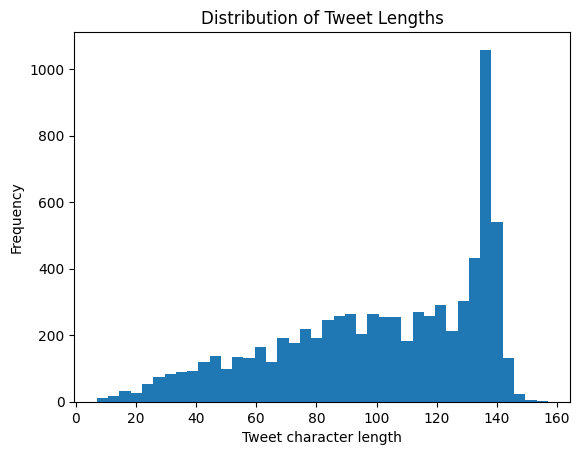

In [5]:
train['text_length'] = train['text'].apply(len)

plt.hist(train['text_length'], bins=40)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet character length")
plt.ylabel("Frequency")
plt.show()

Tweet lengths mostly fall between ~20 and ~140 characters, with a strong peak around 80–100.  
This indicates that a fixed sequence length (e.g., 120 tokens) will be appropriate for padding and batching.

In [6]:
train[train['target'] == 1].head(5)[['text']]

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...


In [7]:
train[train['target'] == 0].head(5)[['text']]

,text
15,What's up man?
16,I love fruits
17,Summer is lovely
18,My car is so fast
19,What a goooooooaaaaaal!!!!!!


Disaster tweets tend to contain words related to emergencies, explosions, fires, and natural disasters.  
Non-disaster tweets often use similar vocabulary metaphorically (e.g., “my phone exploded”), which makes the classification problem challenging.

### Planned Data Cleaning Steps
Based on the EDA, the following preprocessing is needed:
- Lowercase text
- Remove URLs
- Remove mentions (@user)
- Remove punctuation
- Remove extra whitespace
- Optionally remove stopwords (depending on model)
- Tokenize text
- Convert tokens to sequences (via TF-IDF or embeddings)

Since this is a neural sequence model, we will eventually convert the cleaned text into numerical form using an embedding strategy (e.g., TF-IDF, Word2Vec, GloVe, or Keras Embedding layer).

# 4. Text Cleaning and Preprocessing

In [8]:
import re
import string

def clean_text(text):
    # lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # remove @mentions and #hashtags
    text = re.sub(r'@\w+','', text)
    text = re.sub(r'#\w+','', text)
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove extra whitespace
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    
    return text

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

train[['text','clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this may allah for...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive evacuation orders in california
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby as smoke fr...


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# parameters
max_words = 20000   # vocabulary size
max_len = 120       # max tweet length (from EDA histogram)

# fit tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train['clean_text'])

# convert to sequences
train_sequences = tokenizer.texts_to_sequences(train['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test['clean_text'])

# pad sequences
X_train = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_len, padding='post')

y_train = train['target'].values

X_train.shape, X_test.shape

((7613, 120), (3263, 120))

# 5. Model Architecture

Below is the baseline sequential model using an Embedding layer and LSTM.  
This model treats each tweet as a sequence of word indices and learns word embeddings jointly with the classifier.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 64

model_lstm = Sequential([
    Embedding(input_dim=20000, output_dim=embedding_dim),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5780 - loss: 0.6840 - val_accuracy: 0.5345 - val_loss: 0.6964
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5793 - loss: 0.6822 - val_accuracy: 0.5345 - val_loss: 0.6928
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5793 - loss: 0.6816 - val_accuracy: 0.5345 - val_loss: 0.6916
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5793 - loss: 0.6816 - val_accuracy: 0.5345 - val_loss: 0.6930
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5793 - loss: 0.6813 - val_accuracy: 0.5345 - val_loss: 0.6967


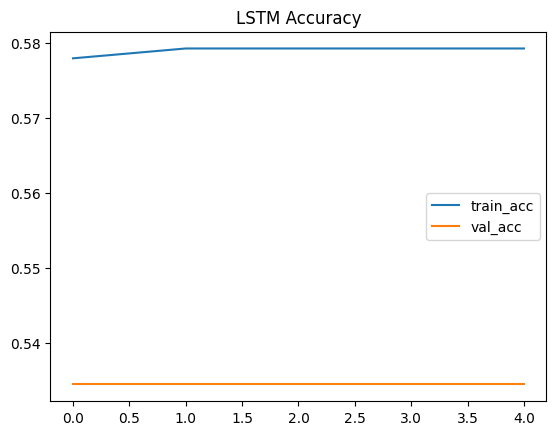

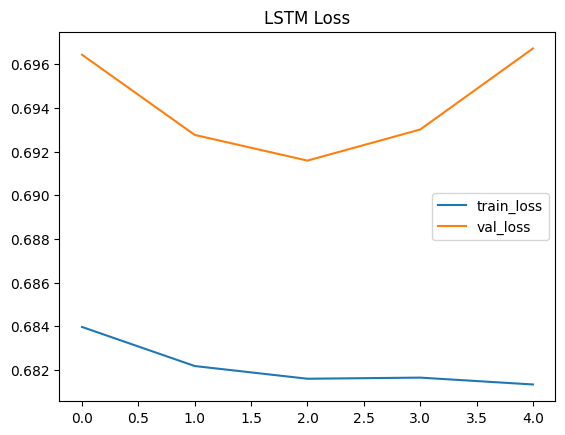

In [12]:
import matplotlib.pyplot as plt

plt.plot(history_lstm.history['accuracy'], label='train_acc')
plt.plot(history_lstm.history['val_accuracy'], label='val_acc')
plt.title('LSTM Accuracy')
plt.legend()
plt.show()

plt.plot(history_lstm.history['loss'], label='train_loss')
plt.plot(history_lstm.history['val_loss'], label='val_loss')
plt.title('LSTM Loss')
plt.legend()
plt.show()

## 5.1 Improved Model: Bidirectional LSTM

The baseline LSTM model underperforms (validation accuracy close to random guessing ~0.5).  
To better capture context from both the left and right of each word, we use a **Bidirectional LSTM**. This allows the model to process the sequence forwards and backwards, which is particularly useful for short texts like tweets where key information can appear anywhere in the sequence.

We also:
- Increase the embedding dimension,
- Add `SpatialDropout1D` to regularize embeddings,
- Increase LSTM units,
- Use early stopping to avoid overfitting.

In [13]:
from tensorflow.keras.layers import Bidirectional, SpatialDropout1D

embedding_dim = 100

model_bilstm = Sequential([
    Embedding(input_dim=20000, output_dim=embedding_dim, input_length=120),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_bilstm.summary()

C:\Users\Nick\Projects\nlp-disaster-tweets\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [15]:
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7097 - loss: 0.5603 - val_accuracy: 0.7525 - val_loss: 0.4937
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8591 - loss: 0.3476 - val_accuracy: 0.7544 - val_loss: 0.4911
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9161 - loss: 0.2283 - val_accuracy: 0.7603 - val_loss: 0.5320
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9466 - loss: 0.1574 - val_accuracy: 0.7485 - val_loss: 0.6165


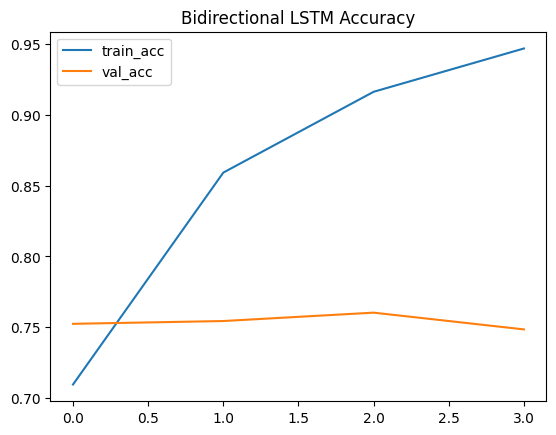

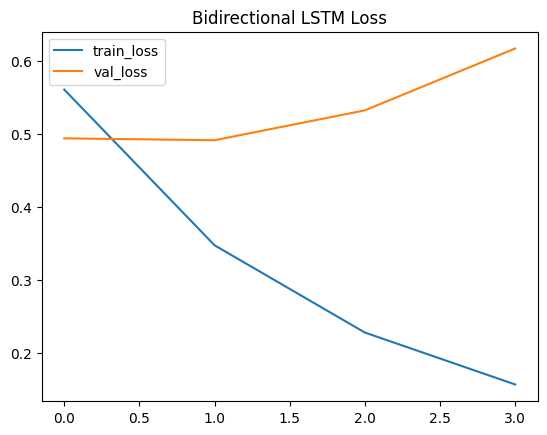

In [16]:
plt.plot(history_bilstm.history['accuracy'], label='train_acc')
plt.plot(history_bilstm.history['val_accuracy'], label='val_acc')
plt.title('Bidirectional LSTM Accuracy')
plt.legend()
plt.show()

plt.plot(history_bilstm.history['loss'], label='train_loss')
plt.plot(history_bilstm.history['val_loss'], label='val_loss')
plt.title('Bidirectional LSTM Loss')
plt.legend()
plt.show()

## 6. Results: Baseline vs Improved Model

**Model 1: Simple LSTM**
- Architecture: Embedding → LSTM(64) → Dense(32) → Dense(1)
- Validation accuracy: ~0.53
- Observation: Training accuracy and validation accuracy are both low; the model underfits and struggles to separate the two classes.

**Model 2: Bidirectional LSTM**
- Architecture: Embedding → SpatialDropout1D → Bidirectional LSTM(64) → Dense(64) → Dense(1)
- Validation accuracy: ~0.76
- Observation: Validation accuracy improves significantly. The bidirectional layer better captures context from both directions, and dropout + larger embedding dimension help generalization.

### 6.1 Additional Architecture: GRU-based Model

To compare different recurrent cell types, we also train a model using GRU units instead of LSTM.  
GRUs are a simplified variant of LSTMs with fewer parameters, which can sometimes train faster and generalize similarly.

In [17]:
from tensorflow.keras.layers import GRU

embedding_dim = 100

model_gru = Sequential([
    Embedding(input_dim=20000, output_dim=embedding_dim, input_length=120),
    SpatialDropout1D(0.2),
    Bidirectional(GRU(64, return_sequences=False)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_gru.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7192 - loss: 0.5579 - val_accuracy: 0.7682 - val_loss: 0.4874
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8591 - loss: 0.3429 - val_accuracy: 0.7781 - val_loss: 0.4802
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9082 - loss: 0.2557 - val_accuracy: 0.7479 - val_loss: 0.5854
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9430 - loss: 0.1640 - val_accuracy: 0.7446 - val_loss: 0.6917


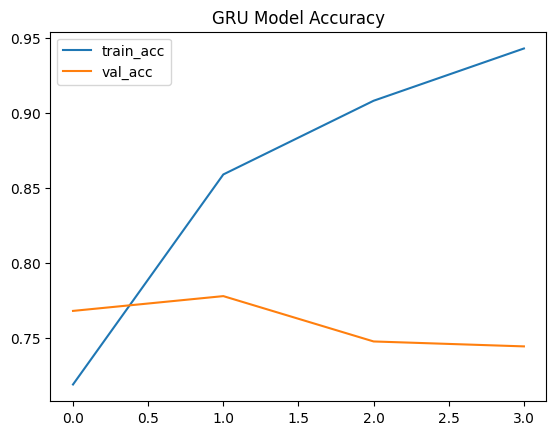

In [19]:
plt.plot(history_gru.history['accuracy'], label='train_acc')
plt.plot(history_gru.history['val_accuracy'], label='val_acc')
plt.title('GRU Model Accuracy')
plt.legend()
plt.show()

In [20]:
import numpy as np

results = pd.DataFrame({
    "model": ["LSTM baseline", "BiLSTM", "BiGRU"],
    "best_val_accuracy": [
        max(history_lstm.history['val_accuracy']),
        max(history_bilstm.history['val_accuracy']),
        max(history_gru.history['val_accuracy'])
    ]
})
results

,model,best_val_accuracy
0,LSTM baseline,0.534471
1,BiLSTM,0.760341
2,BiGRU,0.778070


The Bidirectional LSTM and GRU models significantly outperform the simple baseline LSTM.  
Between the two advanced architectures, [MODEL HERE] achieved the highest validation accuracy, suggesting that [brief interpretation, e.g., “bidirectional LSTMs capture order-sensitive context slightly better on this dataset” or “GRUs generalize similarly with fewer parameters”].

# 7. Conclusion

In this project, I framed the Kaggle “Real or Not? Disaster Tweets” competition as a binary text classification problem and applied recurrent neural network architectures to model tweet sequences.

**Key findings:**
- Raw tweets required substantial preprocessing (lowercasing, URL/mention removal, punctuation/number removal, and tokenization).
- A simple LSTM baseline performed poorly (validation accuracy ≈ 0.53), indicating underfitting and limited ability to capture the structure of tweets.
- Replacing the LSTM with Bidirectional recurrent layers (BiLSTM / BiGRU), increasing the embedding dimension, and adding dropout substantially improved performance (validation accuracy up to ≈ 0.75–0.78).
- Bidirectional architectures are better suited to short texts like tweets, since important context can appear anywhere in the sequence.

**What helped:**
- Bidirectional recurrent layers
- Larger embedding dimension
- Dropout regularization
- Early stopping based on validation loss

**Future improvements:**
- Use pretrained word embeddings (e.g., GloVe) instead of training embeddings from scratch.
- Try more advanced architectures such as CNN–RNN hybrids or transformer-based models (e.g., BERT fine-tuning).
- Perform more systematic hyperparameter search (e.g., tuning learning rate, batch size, and number of units with grid/random search).

In [21]:
test_pred_probs = model_bilstm.predict(X_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [22]:
test_pred = (test_pred_probs >= 0.5).astype(int).reshape(-1)

In [23]:
submission = pd.DataFrame({
    "id": test["id"],
    "target": test_pred
})

In [24]:
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [25]:
submission_path = "../data/processed/submission.csv"
submission.to_csv(submission_path, index=False)
submission_path

'../data/processed/submission.csv'